In [1]:
import numpy as np
import pandas as pd
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_pickle('../../data/processed/merged/state0_new_df.pkl')
print(df.shape)

(16574, 15)


In [3]:
df = df[(df['eventType'] == 5) & (df['is_ios'] == 0)]

df = df.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventGPSSignalStrength', 'eventSensorDetectionMthd', 'source_file', 'gpsP75LateralAccel', 'gpsP95LateralAccel'])
df = df.dropna(subset=['bearingAngleChange'])
corr_matrix = df.corr()

In [4]:
df.columns

Index(['eventDurationSeconds', 'eventStartSpeed', 'eventEndSpeed',
       'gpsMedianLateralAccel', 'bearing_angular_change_per_second',
       'bearingAngleChange', 'gps_radius'],
      dtype='object')

In [5]:
scalar = StandardScaler()
X_scaled = scalar.fit_transform(df)

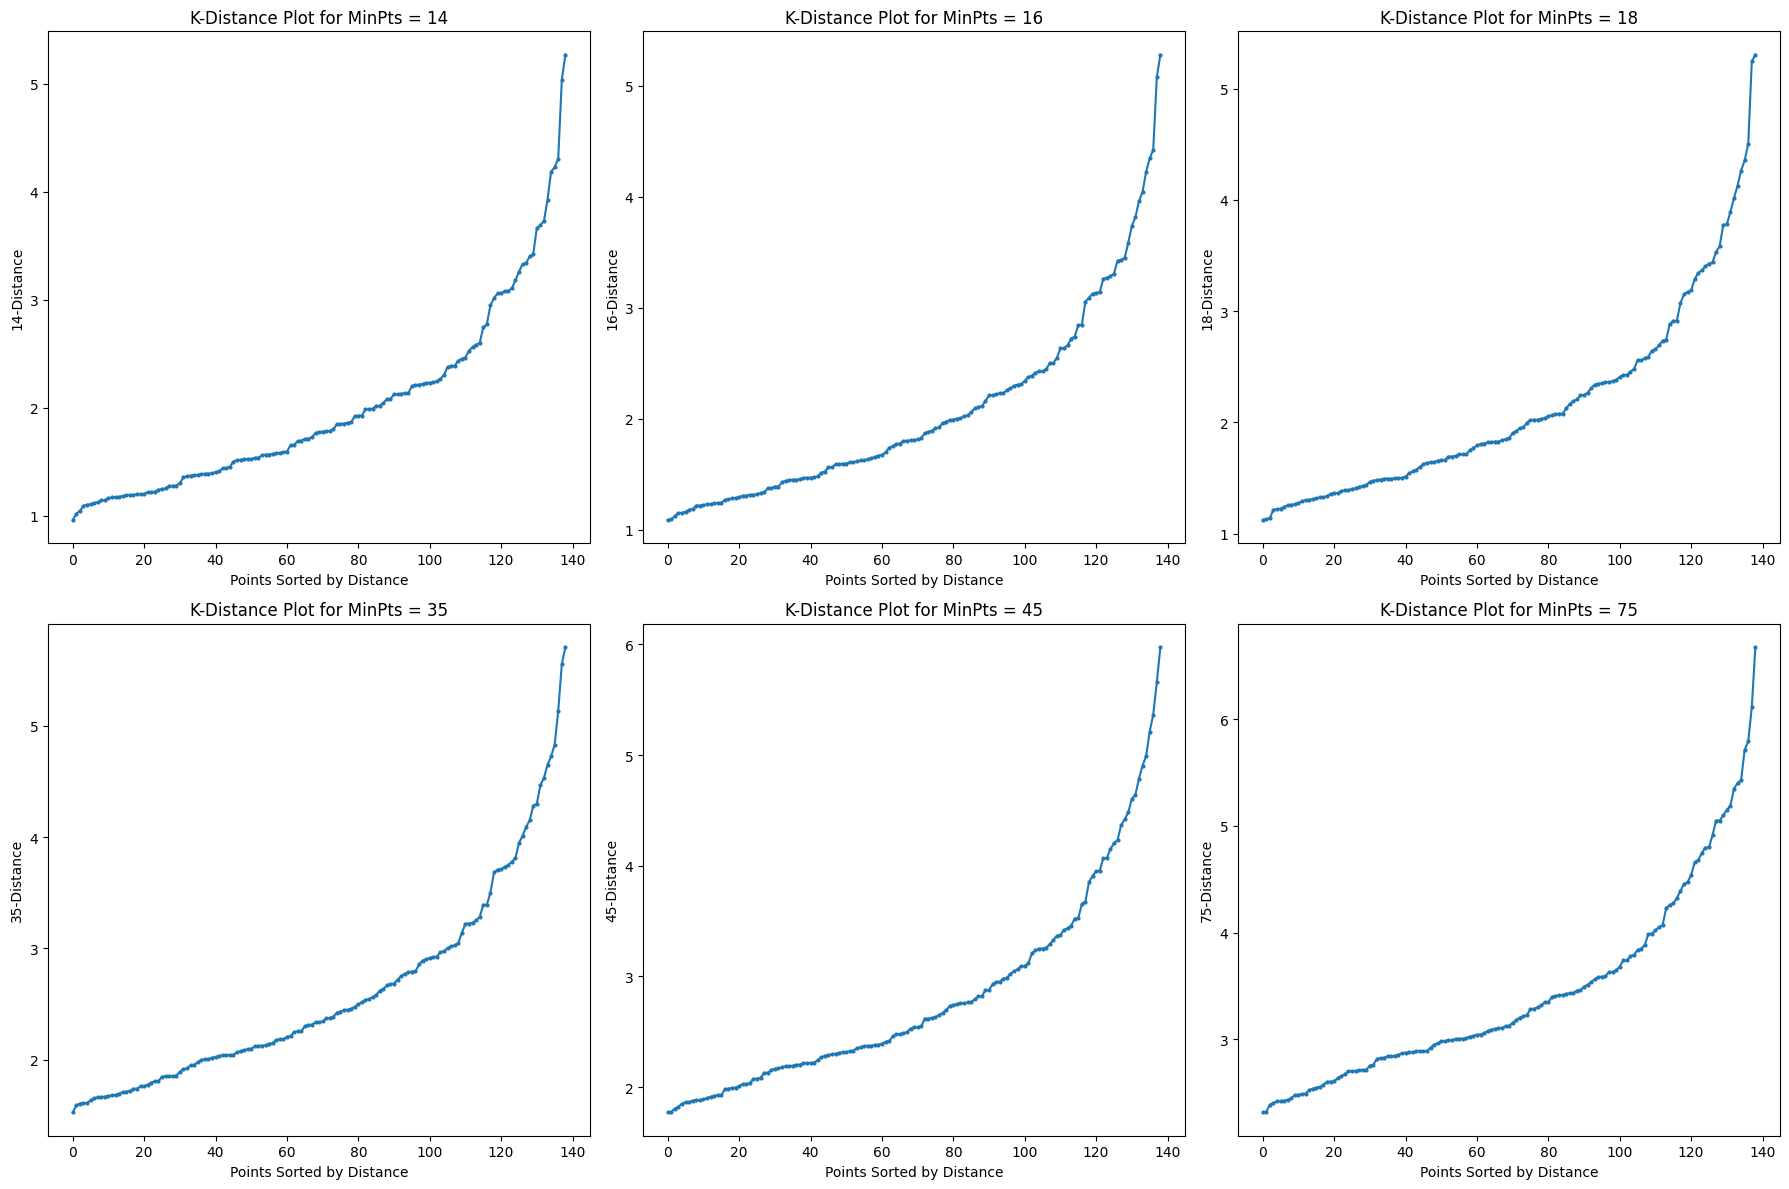

In [6]:
min_pts_candidate = [14, 16, 18, 35, 45, 75]
plt.figure(figsize=(18, 12))

for i, min_pts in enumerate(min_pts_candidate):
    nn = NearestNeighbors(n_neighbors=min_pts, n_jobs=-1).fit(X_scaled)
    distances, indices = nn.kneighbors(X_scaled)

    k_distances = distances[:, min_pts - 1]
    k_distances = np.sort(k_distances, axis=0)
    
    plt.subplot(2, 3, i + 1)
    plt.plot(k_distances, marker='o', markersize=2)
    
    plt.title(f'K-Distance Plot for MinPts = {min_pts}')
    plt.xlabel('Points Sorted by Distance')
    plt.ylabel(f'{min_pts}-Distance')
    
    
plt.tight_layout()
plt.show()

In [7]:
results = []
N_total = X_scaled.shape[0]

for min_pts in range(4, 74, 2):
    for eps in np.arange(0.2, 2, 0.1):
        db = DBSCAN(eps=eps, min_samples=min_pts, n_jobs=-1).fit(X_scaled)
        labels = db.labels_
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        noise_pct = (n_noise / N_total) * 100
        
        if n_clusters >= 2:
            sil_score = silhouette_score(X_scaled, labels)
        else:
            sil_score = -1

        results.append({
            'MinPts': min_pts,
            'Epsilon': eps,
            'N_Clusters': n_clusters,
            'Noise_Pct': f'{noise_pct:.2f}%',
            'Silhouette_Score': sil_score
        })

results_df = pd.DataFrame(results).sort_values(by=['N_Clusters', 'Noise_Pct'], ascending=[False, True])
results_df['Noise_Num'] = results_df['Noise_Pct'].str.replace('%', '').astype(float)
filtered_results = results_df[results_df['Noise_Num'] <= 15.0]
print(filtered_results.drop(columns=['Noise_Num']).head(30))

Empty DataFrame
Columns: [MinPts, Epsilon, N_Clusters, Noise_Pct, Silhouette_Score]
Index: []
